In [1]:
import MDRMF as mf
from MDRMF.models import RFModeller
from matplotlib import pyplot as plt

In [2]:
data = mf.MoleculeLoader(datafile="10K.csv", smi_col="SMILES", scores_col="r_i_docking_score").df
feat = mf.Featurizer(data)
features = feat.featurize("morgan", radius=2, nBits=256)

In [3]:
X = features
y = data['scores']
ids = data['SMILES']

dataset = mf.Dataset(X=X, y=y, ids=ids)
dataset_model = mf.Dataset(X=X, y=y, ids=ids)
dataset

<Dataset X.shape: (9898, 256), y.shape: (9898,), w.shape: (9898,), ids: ['C[C@@H](NC(=O)N1C[C@H](c2ccccc2)[C@H]2COCC[C@H]21)c1ccc(NC(=O)NC2CC2)cc1'
 'O=C(Nc1cccc(C(=O)N2CCC(c3c[nH]c4ncccc34)CC2)c1)[C@@H]1Cc2ccccc2O1'
 'Cc1nn(-c2ccccc2)c2nc(C(=O)N3CCC([C@H]4C(=O)Nc5ccccc54)CC3)ccc12' ...
 'Cn1cccc(C(=O)N2CCN(C3CC3)c3ccc(Cl)cc32)c1=O'
 'O=C([O-])[C@H]1CC[C@@H](C(=O)N2CCCc3ccccc32)CC1'
 'CCNS(=O)(=O)c1cc(NCCOC)ccn1']>

In [4]:
from MDRMF import Dataset
from MDRMF.models import Modeller

class Model:
    def __init__(self, model: Modeller) -> None:
        self.model = model

    def train(self):
        self.model.fit()

    def predict(self, dataset: Dataset):
        return self.model.predict(dataset)
    
    @property
    def results(self):
        return self.model.results

In [5]:
import numpy as np
from sklearn.metrics import r2_score
import copy

class Evaluator:
    def __init__(self, original_dataset, metrics, k_values):
        self.dataset = copy.deepcopy(original_dataset)
        self.metrics = metrics
        self.k_values = [int(k) for k in k_values]

    def evaluate(self, model, model_dataset):
        results = {}
        for metric in self.metrics:
            if metric == "R2_model":
                results[metric] = self.r2_model(model, model_dataset)
            else:
                for k in self.k_values:
                    if metric == "top-k":
                        results[f"top-{k}"] = self.top_n_correct(k, model)
                    elif metric == "R2_k":
                        results[f"R2_k-{k}"] = self.r2_n(k, model)
        return results

    def top_n_correct(self, n, model):
        model_predictions = model.predict(self.dataset)
        correct_preds_indices = np.argsort(model_predictions)[:n]
        top_n_real_indices = np.argsort(self.dataset.y)[:n]
        return np.mean(np.isin(correct_preds_indices, top_n_real_indices))


    def r2_model(self, model, model_dataset):
        '''
        Returns the R2 value of the internal model
        '''

        # Find missing points in the model_dataset
        training_points = self.dataset.missing_points(self.dataset, model_dataset)

        y_true = training_points.y
        y_pred = model.predict(training_points)

        return r2_score(y_true, y_pred)
    

    def r2_n(self, n, model):
        # Similar to top_n_correct but here we calculate the r2 score for the top n points
        model_predictions = model.predict(self.dataset)
        top_n_pred_indices = np.argsort(model_predictions)[:n]

        # Get top n points as a Dataset
        top_n_dataset = self.dataset.get_points(top_n_pred_indices)

        y_pred = model.predict(top_n_dataset)
        
        return r2_score(top_n_dataset.y, y_pred)



In [6]:
metrics = ['top-k', 'R2_k']
k_values = ['100']
eval = Evaluator(dataset, metrics, k_values)

In [7]:
dataset_model = mf.Dataset(X=X, y=y, ids=ids)
rf_model = RFModeller(
    dataset=dataset_model,
    evaluator=eval,
    iterations=60,
    initial_sample_size=30,
    acquisition_size=30,
    acquisition_method="greedy",
    n_estimators=50
)

In [8]:
model = Model(model=rf_model)
model.train()

Iteration 1, Results: {'top-100': 0.03, 'R2_k-100': -0.022208645108593883}
Iteration 2, Results: {'top-100': 0.04, 'R2_k-100': 0.09021876889072467}
Iteration 3, Results: {'top-100': 0.07, 'R2_k-100': 0.16006603942309483}
Iteration 4, Results: {'top-100': 0.09, 'R2_k-100': 0.22580474564734188}
Iteration 5, Results: {'top-100': 0.09, 'R2_k-100': 0.26732632816395907}
Iteration 6, Results: {'top-100': 0.13, 'R2_k-100': 0.2845813073384512}
Iteration 7, Results: {'top-100': 0.13, 'R2_k-100': 0.45663777173488407}
Iteration 8, Results: {'top-100': 0.15, 'R2_k-100': 0.4511211191053688}
Iteration 9, Results: {'top-100': 0.17, 'R2_k-100': 0.33390294540647336}
Iteration 10, Results: {'top-100': 0.18, 'R2_k-100': 0.33091176843391223}
Iteration 11, Results: {'top-100': 0.19, 'R2_k-100': 0.3838160757032236}
Iteration 12, Results: {'top-100': 0.19, 'R2_k-100': 0.42527896960751066}
Iteration 13, Results: {'top-100': 0.19, 'R2_k-100': 0.4986331552952481}
Iteration 14, Results: {'top-100': 0.21, 'R2_k-10

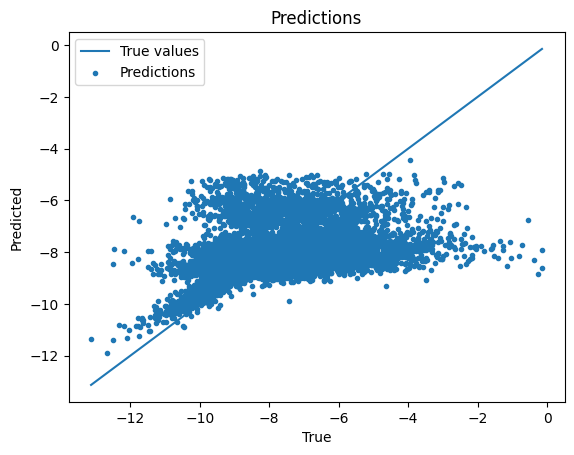

In [9]:
predictions = model.predict(dataset)

plt.plot(dataset.y, dataset.y, label="True values")
plt.scatter(dataset.y, predictions, marker=".", label="Predictions")
plt.gca().set(xlabel='True', ylabel='Predicted', title='Predictions')
plt.legend()

In [10]:
model.results

{1: {'top-100': 0.03, 'R2_k-100': -0.022208645108593883},
 2: {'top-100': 0.04, 'R2_k-100': 0.09021876889072467},
 3: {'top-100': 0.07, 'R2_k-100': 0.16006603942309483},
 4: {'top-100': 0.09, 'R2_k-100': 0.22580474564734188},
 5: {'top-100': 0.09, 'R2_k-100': 0.26732632816395907},
 6: {'top-100': 0.13, 'R2_k-100': 0.2845813073384512},
 7: {'top-100': 0.13, 'R2_k-100': 0.45663777173488407},
 8: {'top-100': 0.15, 'R2_k-100': 0.4511211191053688},
 9: {'top-100': 0.17, 'R2_k-100': 0.33390294540647336},
 10: {'top-100': 0.18, 'R2_k-100': 0.33091176843391223},
 11: {'top-100': 0.19, 'R2_k-100': 0.3838160757032236},
 12: {'top-100': 0.19, 'R2_k-100': 0.42527896960751066},
 13: {'top-100': 0.19, 'R2_k-100': 0.4986331552952481},
 14: {'top-100': 0.21, 'R2_k-100': 0.3816843395304025},
 15: {'top-100': 0.22, 'R2_k-100': 0.3815678720412846},
 16: {'top-100': 0.23, 'R2_k-100': 0.33335128931672753},
 17: {'top-100': 0.26, 'R2_k-100': 0.3251654691706217},
 18: {'top-100': 0.31, 'R2_k-100': 0.36404767

In [11]:
max(model.results.keys())

60

In [29]:
top_100_list = []
iteration_list = []
for i in range(0, max(model.results.keys())+1, 10):
    if i == 0: i = 1

    if i in model.results:
        top_100_list.append(model.results[i]['top-100'])
        iteration_list.append(i)


In [30]:
print(top_100_list)
print(iteration_list)

[0.03, 0.18, 0.33, 0.35, 0.47, 0.54, 0.56]
[1, 10, 20, 30, 40, 50, 60]


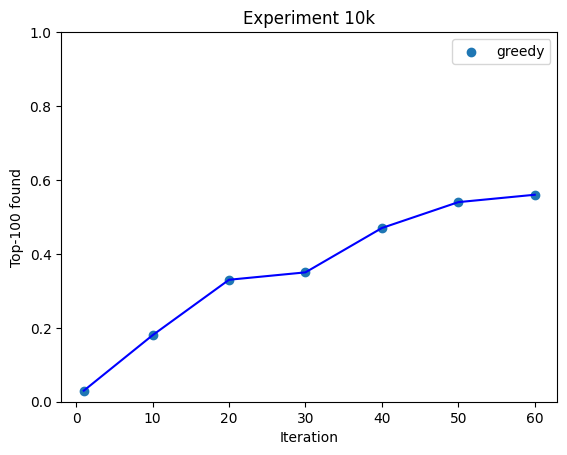

In [39]:
plt.scatter(iteration_list, top_100_list, marker="o", label="greedy")
plt.plot(iteration_list, top_100_list, linestyle="-", color="blue")
plt.gca().set(xlabel='Iteration', ylabel='Top-100 found', title='Experiment 10k')
plt.ylim(0, 1)
plt.legend()